Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

# Week 9 - Clustering

For this assignment, you will use the *digits* dataset.

The components of this assignment are:
1. Load the digits dataset into a Pandas data frame.
1. Preprocess the digits dataset.
1. Examine how many clusters you may need using the elbow method.
1. Cluster the digits dataset using K-means and evaluate using adjusted rand index.
1. Optional: See how the ARI changes as you alter the K-means parameters.
1. Optional: Use clustering as a classifier and compare to Random Forest.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/Users/syedather/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/syedather/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


## Task 1. Load the digits dataset into a Pandas data frame.

The digits dataset represents images of handwritten digits. Each image is a 32x32 bitmap. To create a numerical dataset representing the images, each image was divided into non-overlapping blocks of 4x4, and the number of set pixels in each block is counted.

Thus, each image is represented by an 8x8 matrix of integers in the range 0-16. Each sample in the dataset therefore has 64 attributes. There are a total of 1,797 samples in the dataset we will use.

Therefore, the digits dataset should be loaded into a Pandas dataframe with 1,797 rows and 64 columns.

In this task, you will load the digits dataset (http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes) into a Pandas dataframe. Note that the final column in this dataset is the correct label (an integer in the range 0-9).

Load the attributes into a Pandas dataframe named **digits**. This dataframe should *not* include the final column, as we only want to load the features here.

Instead, save the final column into a Pandas series named **labels**.

In [2]:
import pandas as pd
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"
df = pd.read_csv(url, header=-1)
digits = df.iloc[:, :-1]
labels = df.iloc[:,-1]


In [3]:
assert digits.shape == (1797, 64)
assert labels.shape == (1797,)
assert digits.sum().sum() == 561718
assert all((0 <= labels) & (labels <= 9))

## Task 2. Preprocess the digits dataset.

Standardize the data so that each column has a mean of (or very close to) zero and a standard deviation of (or very close to) 1. Make sure the resulting data is a Pandas dataframe (if it is not, convert it to one using pd.DataFrame).

Note that some of the columns are all zeros across all samples. In this case, you can leave the column as is. In theory you could remove those columns as they do not contribute any information to clustering, but in our case they do not affect the results so we will keep them. For this reason, our assertions makes sure that all the columns have a standard variation of one **except** those columns that are all zeros.

In [4]:
import numpy as np
digits = ((digits - digits.mean()) / digits.std(ddof=0)).fillna(0)

In [5]:
assert digits.shape == (1797, 64)
assert all(np.isclose(digits.mean(), 0))
assert all(np.isclose(digits.std(ddof=0), 1) == (digits.sum() != 0))
assert np.isclose(digits.sum().sum(), 0)

## Task 3. Examine how many clusters you may need using the elbow method.

The K-means algorithm requires us to specify the number of clusters. One way to assess this is using the elbow method.

Use the elbow method and see if there is a clear number of clusters that make sense in the digits dataset. Note that this is just for exploratory purposes; we know the number of clusters should be 10, and that is what we will use in the future components of this exercise.

The elbow method consists of visualizing the sum of squared distances between samples and their closest cluster center. This is done by creating a scatter plot where the number of clusters used in K-means is provided on the X axis and the sum of squared distances is provided on the Y axis. If there is a clear inflection point, that can be an indicator of the ideal number of clusters.

Run the K-means algorithm on the digits dataset 25 times. In the first run set the number of clusters to 1, in the second to 2, and so on through 25. For each run, collect the sum of squared distances. Save these into a list named **ssds**.

Create an elbow plot and examine whether you can see a clear inflection point.

**Note:**
In order for our assertions to work, make sure you use the default parameters for KMeans, with the exception of random_state, which you should set to 126, i.e. to run with one cluster:
```python
KMeans(n_clusters=1, random_state=126)
```

and so forth.

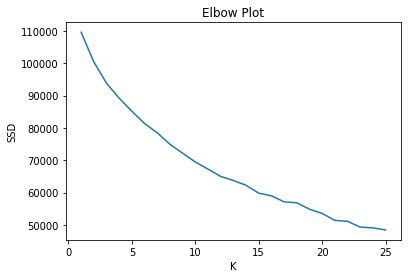

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_elbow(dataset, max_clusters):
    """Plot elbow curve for k-means."""
    inertias = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=126)
        kmeans.fit(dataset)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), inertias)
    plt.title("Elbow Plot")
    plt.xlabel("K")
    plt.ylabel("SSD")
    plt.show()
    return inertias

ssds = plot_elbow(digits, 25)

# There is no clear inflection point.
    

In [7]:
assert len(ssds) == 25
assert np.isclose(np.mean(ssds), 68158.8514102)

## Task 4. Cluster the digits dataset using K-means and evaluate using adjusted rand index.

Go ahead and cluster the dataset using K-means. 

Set the number of clusters to ten and and the random_state to 126:
```python
KMeans(n_clusters=10, random_state=126)
```

Evaluate your clusters using the ARI. You can import the ARI function from sklearn.metrics:

```python
from sklearn.metrics import adjusted_rand_score
```

Save the ARI to the variable *score*. Save the KMeans model to the variable *model*.

In [8]:
from sklearn.metrics import adjusted_rand_score

model = KMeans(n_clusters=10, random_state=126)
labels_true = model.fit(digits)
labels_pred = model.predict(digits)
score = adjusted_rand_score(labels, labels_pred)

In [9]:
assert isinstance(score, float)
assert np.isclose(score, 0.477717062354)
assert len(model.labels_) == 1797
assert sum(model.labels_) == 5881

## Task 5. How does the ARI change when you alter the K-means parameters?
### Optional and ungraded.

Explore the effect on the ARI of changing the KMeans parameters, such as: init, n_init, max_iter.

Compare to other evaluations, such as: homogeneity score, completeness score, and the silhouette coefficient.

In [10]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=10, random_state=126)
labels_true = model.fit(digits)
labels_pred = model.predict(digits)
print("adjusted rand score " + str(adjusted_rand_score(labels, labels_pred)))
print("homogeneity score " + str(homogeneity_score(labels, labels_pred)))


model = KMeans(n_clusters=10, init="random", n_init=20, max_iter=300, random_state=126)
labels_true = model.fit(digits)
labels_pred = model.predict(digits)
print("adjusted rand score " + str(adjusted_rand_score(labels, labels_pred)))
print("homogeneity score " + str(homogeneity_score(labels, labels_pred)))

model = KMeans(n_clusters=10, init="random", n_init=5, max_iter=100, random_state=126)
labels_true = model.fit(digits)
labels_pred = model.predict(digits)
print("adjusted rand score " + str(adjusted_rand_score(labels, labels_pred)))
print("homogeneity score " + str(homogeneity_score(labels, labels_pred)))


adjusted rand score 0.477717062354
homogeneity score 0.607849284657
adjusted rand score 0.461637949354
homogeneity score 0.598426950081
adjusted rand score 0.461637949354
homogeneity score 0.598426950081


## Task 6. Clustering as a classifier?
### Optional and ungraded.

Can you use clustering as a classifier for the digits dataset? How does it compare to some of the classifiers you used last week, such as random forest?

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.26s	69462	0.610	0.658	0.633	0.479	0.606	0.140
random   	0.16s	69995	0.601	0.651	0.625	0.474	0.597	0.158
PCA-based	0.05s	70769	0.669	0.696	0.683	0.558	0.666	0.152
__________________________________________________________________________________


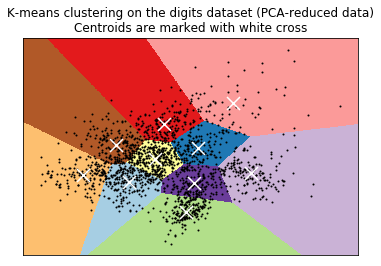

'\nClearly defined decision boundaries. Seems to perform better than the classifiers used in the previous \nassignment. \n'

In [11]:
### Copy-pasted from the tutorial ###

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

"""
Clearly defined decision boundaries. Seems to perform better than the classifiers used in the previous 
assignment. 
"""